# <center>ASTR4004/8004 - Simulations - Part 4</center>

This notebook builds a simple semi-analytic galaxy formation model, based on Qin+17 (1703.04895)

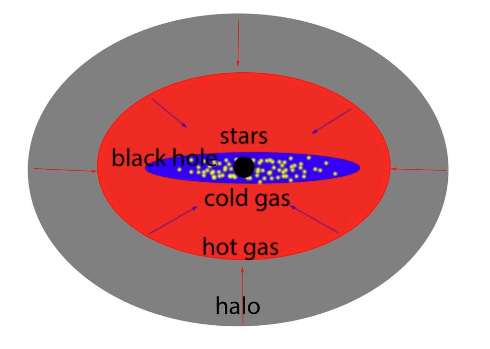

## Useful packages

In [1]:
import matplotlib
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from astropy import units
from astropy.cosmology import Planck15 as cosmo
from hmf import MassFunction
from scipy.interpolate import interp1d
import commah
from scipy.special import gamma

## dark matter halo models

### halo mass function
The halo mass function quantifies the number density of halos as a function of their masses

In [2]:
def sample_halo_masses(num_samples, z=30, Mmin=8, Mmax=15, hmf_model='Tinker10'):
    """
    Sample halo masses using the hmf package based on the specified HMF.
    
    Parameters:
    - num_samples: Number of halo masses to sample.
    - z: Redshift at which to sample the HMF.
    - Mmin: Minimum halo mass in units of solar mass in logrithmic scale.
    - Mmax: Maximum halo mass in units of solar mass in logrithmic scale.
    - hmf_model: HMF model (PS, ST, Tinker10, Watson, etc)
    
    Returns:
    - Array of sampled halo masses in units of 1e10 solar mass.
    - Volume of the sample in units of Mpc^3
    """
    
    # Initialize the MassFunction object
    mf = MassFunction(z=z, Mmin=Mmin, Mmax=Mmax, cosmo_model=cosmo, hmf_model=hmf_model)

    # Get the halo mass function (dn/dlogM)
    log10m = np.log10(mf.m)  # Halo masses in M_sun in logirhmic scale
    dndlog10m = mf.dndlog10m  # Number density in (Mpc^-3 M_sun^-1)

    # consider dn/dlog10M as a probability distribution for sampling
    cdf = np.cumsum(dndlog10m)
    volume = cdf[-1]**-1
    cdf *= volume  # Normalize CDF to [0,1]

    # Create an interpolation function for the inverse CDF
    inverse_cdf = interp1d(cdf, log10m, bounds_error=False, fill_value=(Mmin, Mmax))

    # Generate uniform random numbers
    random_values = np.random.uniform(0, 1, num_samples)

    # Sample masses using the inverse CDF
    sampled_masses = 10**(inverse_cdf(random_values)-10)
    
    return sampled_masses, volume

### halo spin parameter
The halo spin parameter characterizes the angular momentum of dark matter halos.

In [3]:
def sample_halo_spins(num_samples, Lmin=0, Lmax=1, mean=0.033, alpha=2.25):
    """
    Sample halo spin parameter based on Angel+16 (1512.00560)

    Parameters:
    - num_samples: Number of halo masses to sample.
    - Lmin: Minimum halo spin parameter.
    - Lmax: Maximum halo spin parameter.
    - mean, alpha: parameter of the Bett+07 function

    Return:
    - Array of the halo spin parameter
    """
    spin = np.linspace(Lmin,Lmax,1000)
    
    prob = 3*np.log(10) / gamma(alpha) * alpha**(alpha-1) * (spin/mean)**3 * np.exp(-alpha*(spin/mean)**(3/alpha))
    cdf = np.cumsum(prob)
    cdf /= cdf[-1]

    inverse_cdf = interp1d(cdf, spin, bounds_error=False, fill_value=(Lmin, Lmax))

    random_values = np.random.uniform(0, 1, num_samples)

    sampled_spins = inverse_cdf(random_values)

    return sampled_spins

### halo growth rate

In [4]:
def halo_growth_rate(halo_mass, z):
    """
    Calculate the halo growth rate using the commah package.

    Parameters:
    - halo_mass: Halo mass in units of 1e10 solar mass
    - z: Redshift

    Returns:
    - Array of the halo growth rate in units of 1e10 solar mass per Gyr
    """
    
    return commah.run('Planck15', zi=z, Mi=halo_mass*1e10, com=False, mah=True)['dMdt'].flatten() * 0.1

### halo radius
To calculate the virial radius based on the virial mass, we follow
$$ R_{\rm vir} = \sqrt[3]{\frac{M_{\rm vir}}{\frac{4}{3}\pi\Delta_{c}\rho_{c}(z)}},$$
where $R_{\rm vir}$, $M_{\rm vir}$, $\Delta_c$ and $\rho_c(z)$ are the virial radius, virial mass, overdensity factor (200 for simplicity) and critical density of the universe at redshift $z$.

In [5]:
def virial_mass_to_radius(halo_mass, z):
    """
    Calculate the virial radius for a given virial mass and redshift.

    Parameters:
    - halo_mass: Halo mass in units of 1e10 solar mass
    - z: Redshift

    Returns:
    - Array of the virial radius in kpc
    """
    
    rho_c_z = cosmo.critical_density(z).to('1e10Msun  kpc**-3').value
    return (3 * halo_mass / 4 / np.pi / 200 / rho_c_z)**(1/3)

## star formation law

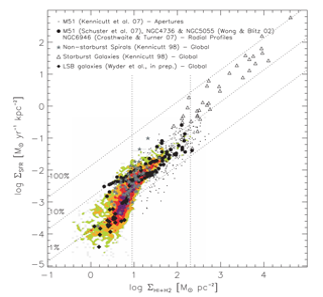

The Kennicutt-Schmidt (KS) Law is a fundamental empirical relationship in astrophysics that describes how the rate of star formation in a galaxy depends on the density of its interstellar gas. This law plays a crucial role in our understanding of galaxy formation and evolution, as it links the physical conditions of a galaxy's gas content to its ability to form new stars. It inspires the following star formation rate calculation:
$$
\dot{M}_* = \epsilon_{\rm SF} \frac{M_{\rm cold} - M_{\rm crit}}{t_{\rm dyn,disc}},
$$
where
$$
 M_{\rm crit} = 2\pi\Sigma_{\rm crit, SF} \left(\frac{V_{\rm circ}}{{\rm km/s}}\right)\left(\frac{r_{\rm disc}}{{\rm kpc}}\right) 10^6{\rm M}_\odot
$$
is the minimum mass of the cold gas disc ($M_{\rm cold}$) before star formation can occur, while $\Sigma_{\rm crit, SF}$, $\epsilon_{\rm SF}$, $r_{\rm disc}$, $V_{\rm circ}$ and $t_{\rm dyn,disc}$ are the normalization from the observation shown above ($\sim 0.6$ at low redshift), the star formation efficiency, as well as the size, circular velocity and dynamical timescale of the cold gas disc. For simplicity, we assume $V_{\rm circ}$ equals to the virial velocity ($V_{\rm vir}$) of the host halo and, assuming full conservation of specific angular momentum, the scale radius of the disc ($r_{\rm s}$) can be approximated from the spin ($\lambda$) and virial radius ($r_{\rm vir}$) of the host halo:
$$
r_{\rm s} = r_{\rm vir} \lambda / \sqrt{2},
$$
and we choose $r_{\rm disc}=3r_{\rm s}$ based on properties of our Milky Way.

In [6]:
def star_formation_rate(coldgas, rdisc, tdyn_disc, efficiency=1, threshold_sf=0.2):
    """
    Calculate the star formation rate.

    Parameters:
    - coldgas: Cold gas disc mass in units of 1e10 solar mass
    - rdisc: Cold gas disc size in units of kpc
    - tdyn_disc: Dynamical timescale on the disc in units of Gyr
    - efficiency: star formation efficiency
    - threshold_sf: normalization of the critical mass

    Returns:
    - Array of star formation rate in 1e10 solar mass per Gyr
    """
    
    # note that kpc/Gyr ~ km/s
    mcrit = 2 * np.pi * rdisc**2 / tdyn_disc * 1e-4 * threshold_sf
    
    sfr = efficiency * (coldgas - mcrit) / tdyn_disc
    sfr[sfr<0] = 0

    return sfr

## Semi-analytic galaxy-formation model

### 1. gas infall / accretion
In this simple semi-analytic galaxy-formation model, once a halo grows larger than the atomic cooling limit it is designated as a galaxy. During one time step, $\Delta t$, additional gas falls into the hot gas component of a galaxy from the IGM when the mass fraction of baryons in the halo is lower than the cosmic mean value, $f_\mathrm{b}{=}\Omega_\mathrm{b}/\Omega_\mathrm{m}$: 
$$
\Delta m_{\mathrm{hot}}{=}{\max}\left[0, f_\mathrm{b}M_\mathrm{vir}{-}\left(m_{\mathrm{\star}}{+}m_{\mathrm{cold}}{+}m_{\mathrm{hot}}{+}m_{\mathrm{eject}}\right)\right],
$$ 
where $m_{\mathrm{\star}},\ m_{\mathrm{cold}},\ m_{\mathrm{hot}}$ and $m_{\mathrm{eject}}$ are the masses of the stellar component, cold gas, hot gas and ejected gas, respectively, and $M_\mathrm{vir}$ is the virial mass of the host halo in which the galaxy forms.

### 2. gas reincorporation
Supernova feedback (see below) will eject gas out of the galaxy, we allow some of them to be reincorporated back with a rate of 
$$
\dot{m}_{\rm incorp} = \epsilon_{\rm incorp} \frac{m_{\mathrm{ejected}}}{t_{\rm dyn}},
$$
where $\epsilon_{\rm incorp}$ and $t_{\rm dyn}$ are the reincorporation efficiency and halo's dynamical time. The total reincorporated mass ($\dot{m}_{\rm incorp} \Delta t$) is removed from the ejected gas reservoir and redistributed into the hot gas reservoir, $\Delta m_{\mathrm{ejected}}=-\Delta m_{\mathrm{hot}}{=}-m_{\mathrm{incorp}}$.

### 3. gas cooling
Similarly, some of the hot gas cools and collapses on to the cold disc. We calculate the cooling rate by
$$
\dot{m}_{\rm cool} = \epsilon_{\rm cool} \frac{m_{\mathrm{hot}}}{t_{\rm dyn}},
$$
where $\epsilon_{\rm cool}$ is the cooling efficiency and the total cooling mass ($\dot{m}_{\rm cool} \Delta t$) is removed from the hot gas reservoir and redistributed into the cold gas disc, $\Delta m_{\mathrm{hot}}=-\Delta m_{\mathrm{cold}}{=}-m_{\mathrm{cool}}$.

### 4. star formation
We follow the KS law (see above) to calculate the star formation rate ($\dot{m}_{*}$) and the total newly formed stars ($\dot{m}_{*} \Delta t$) is removed from the cold gas disc and transferred into the stellar component, $\Delta m_{\mathrm{cold}}=-\Delta m_{\mathrm{*}}$.

### 5. supernova feedback
Assume a simple stellar evolutionary model that 7.5%/Msol of the newly formed stars will go supernovae to heat and eject gas in the galaxy. They will produce a total energy of 
$$
E_{\mathrm{total}} = \alpha_{\rm energy} 0.075{\rm M}_{\odot}^{-1} \Delta M_*\times 10^{51} {\rm erg},
$$
where $\alpha_{\rm energy}$ represent a coupling efficiency (i.e., some energy might get lost). Since the hot gas shares the same virial temperature as the host halo, assuming the mass loading factor for reheating cold gas is a free parameter, $\alpha_{\mathrm{mass}}$, the energy utilized in gas heating can be calculated by
$$
E_{\mathrm{reheat}} = \dfrac{1}{2}\alpha_{\mathrm{mass}}\Delta m_{\star}V_\mathrm{vir}^{2}.
$$
Depending on the available energy and the required energy for re-heating, $E_{\mathrm{reheat}}$, the reheated mass, $m_{\mathrm{reheat}}$, is
$$
m_{\mathrm{reheat}} {=} \mathrm{min}\left[m_\mathrm{cold}, \dfrac{\mathrm{min}\left(E_{\mathrm{total}}, E_{\mathrm{reheat}}\right)}{0.5V_\mathrm{vir}^{2}}\right].
$$
This mass is removed from the cold gas reservoir and redistributed in the hot gas component, $\Delta m_{\mathrm{cold}}= -\Delta m_{\mathrm{hot}}= -m_{\mathrm{reheat}}$. If there is still some energy left after reheating, the supernovae feedback will further remove hot gas from the galaxy, adding it to the ejected component
$$
\Delta m_{\mathrm{eject}}=
\mathrm{min}\left[m_\mathrm{hot}, \dfrac{\mathrm{max}\left(0, E_{\mathrm{total}}- 0.5m_\mathrm{reheat}V_\mathrm{vir}^{2}\right)}{0.5V_\mathrm{vir}^{2}}\right],
$$
which is removed from the hot gas reservoir, $\Delta m_{\mathrm{hot}}=-\Delta m_{\mathrm{eject}}$.

In [7]:
def sam(time_step, z_start, z_end, num_halos, Mmin, Mmax):
    
    #time_step: time step in Gyr
    #z_start, z_end: redshift range
    #num_halos: number of sampled halos
    #Mmin, Mmax: mass range of the sampled halos in units of solar mass and logrithmic scale
    
    Nframe    = int((cosmo.lookback_time(z_start).to('Gyr').value - \
                     cosmo.lookback_time(z_end).to('Gyr').value) / time_step)

    # define a interpolation function to easily map lookback time to redshift
    # This is useful when updating the timestep
    zs = np.linspace(z_start, z_end, 1000)
    lbts = cosmo.lookback_time(zs).to('Gyr').value
    f_lbt_to_z = interp1d(lbts, zs, bounds_error=False, fill_value='extrapolate')

    # -----------------------------
    # Initialization
    # -----------------------------
    global halo_masses, halo_spins, hotgas, coldgas, ejectedgas, stars, z

    z   = z_start
    lbt = cosmo.lookback_time(z).to('Gyr').value
    
    np.random.seed(19)
    # Sample halos at the beginning
    halo_masses, V = sample_halo_masses(num_halos, Mmin=Mmin, Mmax=Mmax, z=z)
    halo_spins     = sample_halo_spins(num_halos)
    hotgas         = np.ones_like(halo_masses) * cosmo.Ob0/cosmo.Om0
    coldgas        = np.zeros_like(halo_masses)
    ejectedgas     = np.zeros_like(halo_masses)
    stars          = np.zeros_like(halo_masses)
    
    # -----------------------------
    # Plotting the halo and stellar mass functions
    # -----------------------------
    fig, axs = plt.subplots(1,2, figsize=(10, 4), sharey=True)
    hmf = np.histogram(np.log10(halo_masses)+10, range=(Mmin,Mmax+2), bins=100,density=True)
    smf = np.histogram(np.log10(stars)+10,       range=(Mmin-2,Mmax), bins=100,density=True)
    hmf_plot, = axs[0].step(hmf[1][:-1], np.log10(hmf[0]/ V))
    smf_plot, = axs[1].step(smf[1][:-1], np.log10(smf[0]/ V))

    axs[0].set_xlim(Mmin, Mmax+2)
    axs[1].set_xlim(Mmin-2, Mmax)
    axs[0].set_xlabel(r'$M_{\rm h}/{\rm M}_\odot$', fontsize=14)
    axs[1].set_xlabel(r'$M_*/{\rm M}_\odot$', fontsize=14)
    axs[0].set_ylabel('mass function', fontsize=14)
    text = axs[1].text(0.98,0.98, 'z=%.1f, lbt=%.2f Gyr'%(z, lbt), 
                       va='top', ha='right', transform=axs[1].transAxes)
    
    plt.tight_layout()

    
    # -----------------------------
    # Semi-Analytic Model Loop
    # -----------------------------
    def evolve(it):

        global halo_masses, halo_spins, hotgas, coldgas, ejectedgas, stars, z
        # dynamic timescale and halo virial properties
        tdyn = 0.1 * cosmo.H(z).to('Gyr**-1').value**-1
        r_vir = virial_mass_to_radius(halo_masses, z)
        v_vir = r_vir / tdyn
        
        # -----------------------------
        # 1. Accretion: Fresh gas is accreted into hot gas
        # Assume the total baryonic fraction remains at the cosmic mean
        hotgas += (halo_masses * cosmo.Ob0/cosmo.Om0 - hotgas - coldgas - ejectedgas - stars)
        
        # -----------------------------
        # 2. Reincorporation: Previously eject gas is reincorporated into hot gas
        mincorp      = reincorporation_efficiency * ejectedgas / tdyn * time_step
        mincorp      = np.minimum(mincorp, ejectedgas)  # Prevent overcooling
        ejectedgas  -= mincorp
        hotgas      += mincorp
        
        # -----------------------------
        # 3. Cooling: Hot gas cools to cold gas
        # Assume tdyn for the cooling time scale 
        # Include an efficiency parameter to adjust the cooling rate
        cooling  = cooling_efficiency * hotgas / tdyn  * time_step
        cooling  = np.minimum(cooling, hotgas)  # Prevent overcooling
        hotgas  -= cooling
        coldgas += cooling
        
        # -----------------------------
        # 4. Star Formation: stars form from cold gas
        radius_ratio_halo_to_gas_disc = 3 * halo_spins/2**0.5
        rdisc = radius_ratio_halo_to_gas_disc * r_vir
        tdyn_disc = radius_ratio_halo_to_gas_disc * tdyn
        new_stars = star_formation_rate(coldgas, rdisc, tdyn_disc, star_formation_efficiency, threshold_star_formation) * time_step

        new_stars = np.minimum(new_stars, coldgas)  # Prevent draining out of gas
        coldgas -= new_stars
        stars   += new_stars
                
        # -----------------------------
        # 5. Supernova Feedback: Affect cold and hot gas
        # Assume a simple stellar evolutionary model that 7.5%/Msol of the newly formed stars will go supernovae at the end of the snapshot
        Esn = 0.075 * new_stars * supernova_energy* sn_feedback_efficiency # erg

        # we first heat some gas from cold to hot gas reservoir
        mheat = sn_mass_loading_factor * new_stars
        mheat = np.minimum(mheat, coldgas) # prevent overheating

        # then need to eject gas if there are energy left
        Eheat = 0.5 * mheat * v_vir**2 
        Eeject = Esn - Eheat
        meject = Eeject *2 / v_vir**2
        meject = np.minimum(meject, hotgas) # prevent overejecting

        coldgas[Eeject>0]    -= mheat[Eeject>0]
        hotgas[Eeject>0]     += mheat[Eeject>0] - meject[Eeject>0]
        ejectedgas[Eeject>0] += meject[Eeject>0]

        # For those having less energy to heat all these mass, we need to recalculate mheat
        mheat[Eeject<0]       = Esn[Eeject<0] *2 / v_vir[Eeject<0]**2 
        coldgas[Eeject<0]    -= mheat[Eeject<0]
        hotgas[Eeject<0]     += mheat[Eeject<0]

        # ---------------
        # 6. Halo growth
        dMdts = halo_growth_rate(halo_masses, z)
        halo_masses += dMdts * time_step

        # ------------------------------
        # 7. Update the plot and move on 
        hmf = np.histogram(np.log10(halo_masses)+10, range=(Mmin,Mmax+2), bins=100,density=True)[0]
        smf = np.histogram(np.log10(stars)+10,       range=(Mmin-2,Mmax), bins=100,density=True)[0]
        hmf_plot.set_ydata(np.log10(hmf/ V))
        smf_plot.set_ydata(np.log10(smf/ V))
        lbt = cosmo.lookback_time(z).to('Gyr').value
        text.set_text('z=%.1f, lbt=%.2f Gyr'%(z, lbt))
        z = f_lbt_to_z(lbt - time_step)
    
    anim = FuncAnimation(
        fig,
        evolve,
        frames = Nframe,
        interval = interval,
        blit = True,
        repeat = False,
    )
   
    return anim


/home/563/yq5547/virtualenvs/py21cmfast/lib/python3.8/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(
/jobfs/127146464.gadi-pbs/ipykernel_1027984/391062631.py:39: RuntimeWarning: divide by zero encountered in log10
  smf = np.histogram(np.log10(stars)+10,       range=(Mmin-2,Mmax), bins=100,density=True)
/home/563/yq5547/virtualenvs/py21cmfast/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/jobfs/127146464.gadi-pbs/ipykernel_1027984/391062631.py:40: RuntimeWarning: divide by zero encountered in log10
  hmf_plot, = axs[0].step(hmf[1][:-1], np.log10(hmf[0]/ V))


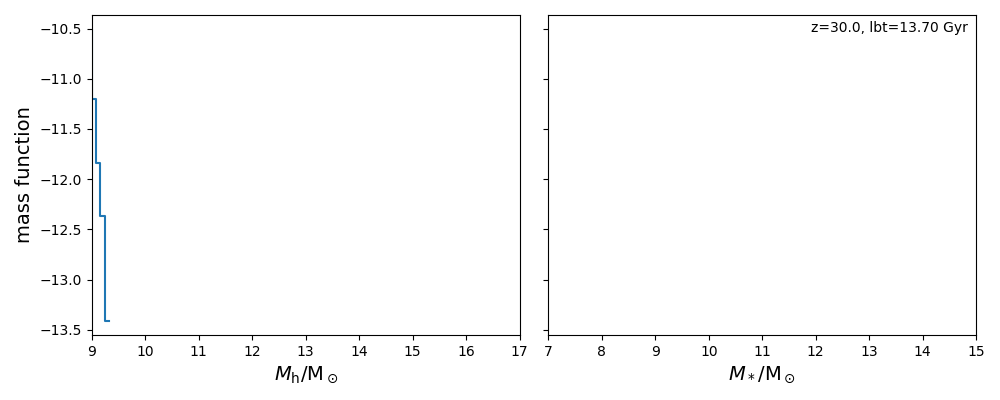

In [8]:
# -----------------------------
# Semi-Analytic Model Parameters
# -----------------------------
cooling_efficiency         = 1.0   # Efficiency in cooling hot gas
threshold_star_formation   = 0.2   # Critical cold gas surface density normalisation
star_formation_efficiency  = 0.01  # Efficiency in forming stars
sn_feedback_efficiency     = 0.5   # Fraction of supernova energy that is couple to gas
sn_mass_loading_factor     = 6.0   # The number of gas in cold gas that get heated per star
reincorporation_efficiency = 1.0   # Efficiency in reincorporating ejected gas
supernova_energy           = (1e51 * units.erg /  (units.Msun * (units.km/units.s)**2 )).to(1).value # individual supernova energy in internal units

plt.close()
interval=0
anim = sam(0.01, 30, 5, 1000, 9, 15)